## Extended Data Figure 7

![title](../assets/EDFig7.png)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import logging
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib_venn
import matplotlib.pyplot as plt

from common import *
sys.path.insert(0, "./prepare_data/")
import connectome_utils
import Figure4_neurons as neurons
import Figure4_graph_tools as graph_tools
import Figure4_generate_grooming_network as gen_network


DATA_PATH = Path(
    "../data"
)
EXPORT_PATH = Path(
    "../results/EDFigure7"
)
EXPORT_PATH.mkdir(exist_ok=True, parents=True)


FIGSIZE = {'width': 1.2, 'length': 0.9}

# disable matplotlib logger
logging.getLogger("matplotlib.font_manager").disabled = True

plt.style.use('./config.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Panel B: parameter sweep of the threshold for the percentage of synapses

### Network construction by looking at the monosynaptic connections with the grooming neurons
- Grooming neurons: JO-C/E/F, aBN, aDN, antennal and neck motor neurons
- We first identify all the neurons that are monosynaptically connected to the grooming neurons. That is, the neurons downstream of the source neurons and upstream of the target neurons. 
- We then consider a single neuron, and look at the percentage of this neuron's incoming synapses that are from the grooming neurons. Similarly, we calculate the percentage of outgoing synapses that are to the grooming neurons. 
- We do a parameter sweep of the threshold for the percentage of synapses. 

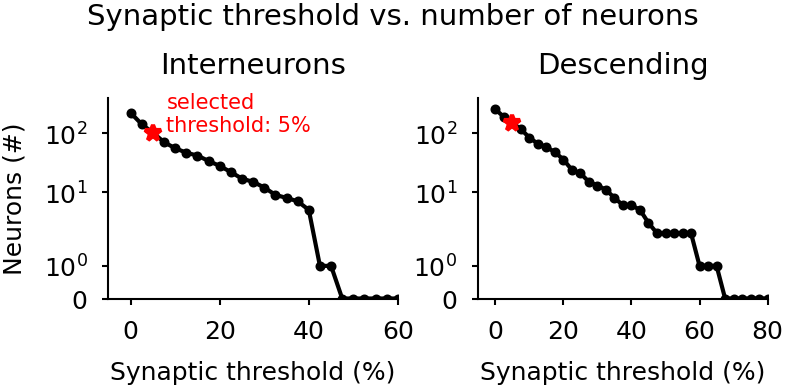

In [10]:
# If you want to generate this data, run /prepare_data/Figure4_generate_grooming_network.py
results_monosynaptic = load_data(DATA_PATH / "Fig4_parameter_sweep.pkl")
results_monosynaptic = dict(sorted(results_monosynaptic.items()))

with plt.style.context("./config.mplstyle"):
    fig, axs = plt.subplots(1,2, figsize=(2.6, 1.2), dpi=300)

    axs[0].plot(
        list(results_monosynaptic.keys()),
        [len(val["IN"]) for _, val in results_monosynaptic.items()],
        marker="o",
        markersize=1.4,
        linewidth=1,
        color="black",
    )

    axs[1].plot(
        list(results_monosynaptic.keys()),
        [len(val["DN"]) for _, val in results_monosynaptic.items()],
        marker="o",
        markersize=1.4,
        linewidth=1,
        color="black",
    )

    SELECTED_THRESHOLD = 5
    for i, neuron_type in enumerate(["IN", "DN"]):
            # put red star on the 5%
        axs[i].plot(
            [SELECTED_THRESHOLD],
            [len(results_monosynaptic[SELECTED_THRESHOLD][neuron_type])],
            marker="*",
            markersize=4,
            linewidth=1,
            color="red",
        )
        axs[i].set_xticks([0, 20, 40, 60, 80, 100], labels=[0, 20, 40, 60, 80, 100])
        axs[i].set_yscale("symlog")
        # axs[i].set_ylabel("Number of neurons")

    axs[0].set_xlabel("Synaptic threshold (%)")
    axs[1].set_xlabel("Synaptic threshold (%)")
    axs[0].set_xlim((-5,60))
    axs[1].set_xlim((-5,80))
    axs[0].set_ylim((0,400))
    axs[1].set_ylim((0,400))


    # axs[0].set_yticks([0,50,100,150,200])
    axs[0].set_ylabel("Neurons (#)")
    axs[0].set_title("Interneurons")
    axs[1].set_title("Descending")

    axs[0].text(
        SELECTED_THRESHOLD + 3,
        len(results_monosynaptic[SELECTED_THRESHOLD]["IN"]) + 8,
        f"selected\nthreshold: 5%",
        fontsize=5,
        color="red",
    )

    plt.suptitle("Synaptic threshold vs. number of neurons", y=1.06)
    plt.tight_layout(pad=-0.01)
    plt.savefig(EXPORT_PATH / f"EDFig7_panelB.png", dpi=300)
    plt.show()

## Panel C: percentage of incoming and outgoing synapses from and to grooming neurons

In [11]:
abn_adn = [
    (name, neuron["id"]) for name, neuron in neurons.neuron_dict["ABN"].items()
] + [(name, neuron["id"]) for name, neuron in neurons.neuron_dict["ADN"].items()]

selected_ins = {
    seg_id: perc
    for seg_id, perc in results_monosynaptic[SELECTED_THRESHOLD]["IN"].items()
    if seg_id not in abn_adn and seg_id in neurons.ALL_NEURONS_REV
}
selected_dns = {
    seg_id: perc
    for seg_id, perc in results_monosynaptic[SELECTED_THRESHOLD]["DN"].items()
    if seg_id not in abn_adn and seg_id in neurons.ALL_NEURONS_REV
}

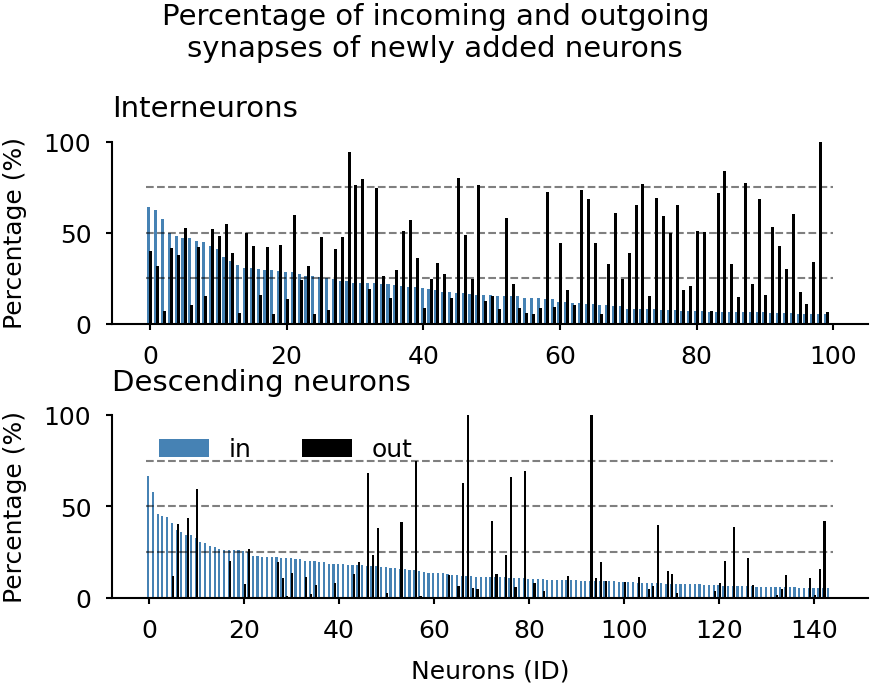

In [12]:
sorted_interneurons = dict(
    sorted(selected_ins.items(), key=lambda x: x[1][0], reverse=True)
)
sorted_descending = dict(
    sorted(selected_dns.items(), key=lambda x: x[1][0], reverse=True)
)

with plt.style.context("./config.mplstyle"):
    fig, axs = plt.subplots(
        2, 1, figsize=(FIGSIZE["width"] * 2.4, FIGSIZE["length"] * 2.4), sharex=False
    )

    for i, (name, (in_per, out_per)) in enumerate(sorted_interneurons.items()):
        axs[0].bar(i - 0.15, in_per, color="steelblue", width=0.45, alpha=1)
        axs[0].bar(i + 0.15, out_per, color="black", width=0.45, alpha=1)

    for i, (name, (in_per, out_per)) in enumerate(sorted_descending.items()):
        axs[1].bar(i - 0.15, in_per, color="steelblue", width=0.45, alpha=1)
        axs[1].bar(i + 0.15, out_per, color="black", width=0.45, alpha=1)

    axs[1].set_xlabel("Neurons (ID)")
    axs[0].set_ylim((0, 100))
    axs[1].set_ylim((0, 100))

    axs[1].legend(
        labels=["in", "out"], bbox_to_anchor=(0.23, 1.0), loc="upper center", ncol=2
    )
    axs[0].hlines(
        [25, 50, 75], -0.5, len(sorted_interneurons), ls="--", color="black", alpha=0.5
    )
    axs[1].hlines(
        [25, 50, 75], -0.5, len(sorted_descending), ls="--", color="black", alpha=0.5
    )

    axs[0].set_ylabel("Percentage (%)")
    axs[1].set_ylabel("Percentage (%)")

    plt.suptitle(
        "Percentage of incoming and outgoing\nsynapses of newly added neurons", y=1.05
    )
    axs[0].set_title("Interneurons", loc="left")
    axs[1].set_title("Descending neurons", loc="left")

    # align y labels
    fig.align_ylabels(axs[:])

    plt.tight_layout(pad=-0.01)
    plt.savefig(EXPORT_PATH / "EDFig7_panelC.png", dpi=300)

    plt.show()

## Panel D: neuron degrees

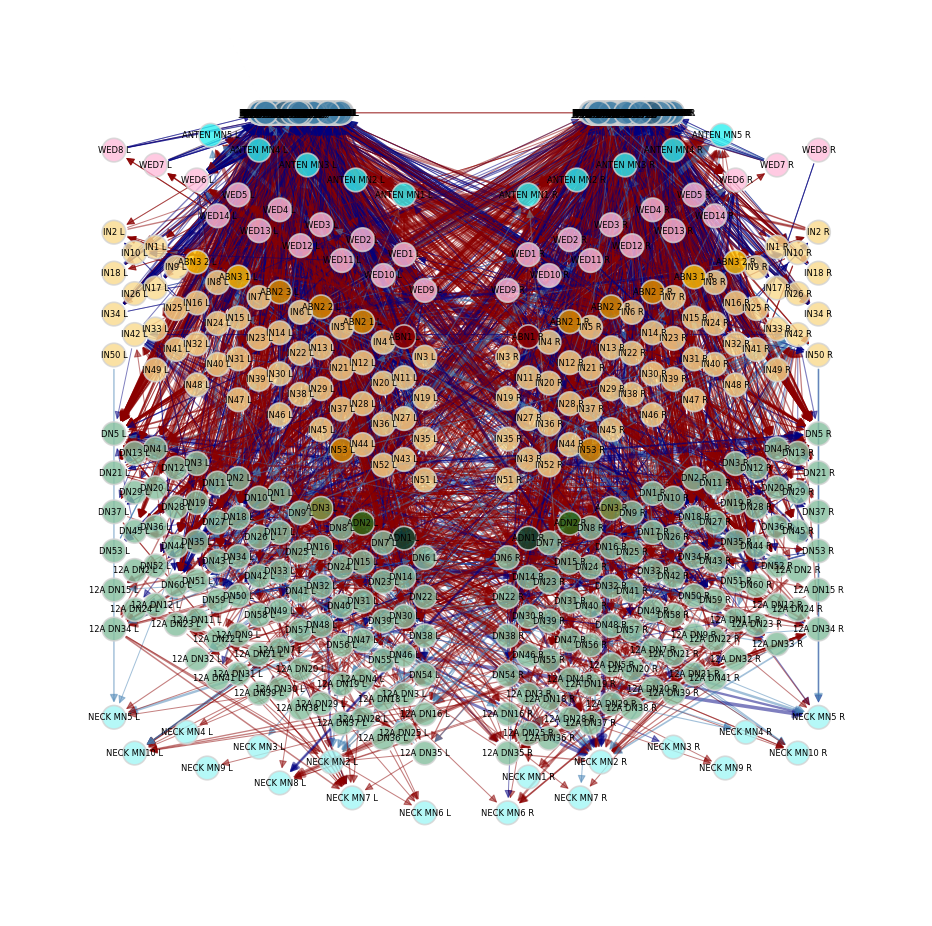

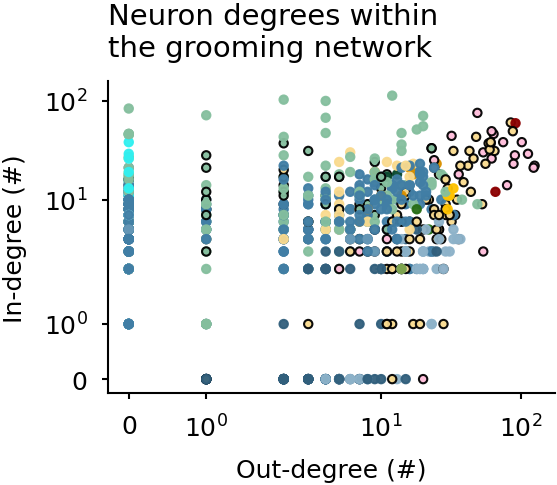

In [13]:
grooming_network = load_data(DATA_PATH / "Fig4_grooming_network_sensory_not_merged.pkl")
# All neurons and connections are shown
network_specs, graph_grooming = connectome_utils.plot_connectivity(
    grooming_network,
    neurons.ALL_NEURONS_REV,
    export_path=EXPORT_PATH / "Fig4_panelC.png",
    node_size=200,
    font_size=5,
    max_w=5,
    synapse_th=0,
)

nodes = list(network_specs["node_labels"].keys())

# get the in and out degree of the neuron
in_degrees = [graph_grooming.in_degree(node) for node in nodes]
out_degrees = [graph_grooming.out_degree(node) for node in nodes]
colors = [neurons.ALL_NEURONS_REV[node]["color"] for node in nodes]
# If inhibitory then encircle it with black lines
edge_colors = [
    (
        "black"
        if neurons.ALL_NEURONS_REV[node]["nt"] == "inhibitory"
        else neurons.ALL_NEURONS_REV[node]["color"]
    )
    for node in nodes
]

with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(figsize=(FIGSIZE["width"] * 1.6, FIGSIZE["length"] * 1.5))

    ax.scatter(
        out_degrees,
        in_degrees,
        s=4,
        color=colors,
        alpha=0.95,
        edgecolors=edge_colors,
        linewidth=0.5,
    )
    # log scale
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    # # label
    ax.set_xlabel("Out-degree (#)")
    ax.set_ylabel("In-degree (#)")
    ax.set_title("Neuron degrees within\nthe grooming network", loc="left")
    # plt.xlim(0,10)
    fig.savefig(
        EXPORT_PATH / "EDFig7_panelD.png", bbox_inches="tight"
    )
    plt.show()

## Panel E: signal flow score of each neuron

In [14]:
grooming_network = load_data(DATA_PATH / "Fig4_grooming_network_sensory_merged.pkl")
adj_sorted_unsigned, nodes, z_sorted = graph_tools.order_signal_flow(grooming_network)
no_layers = 10
layer_neurons, layer_bounds = graph_tools.layer_neurons(nodes, z_sorted, no_layers)

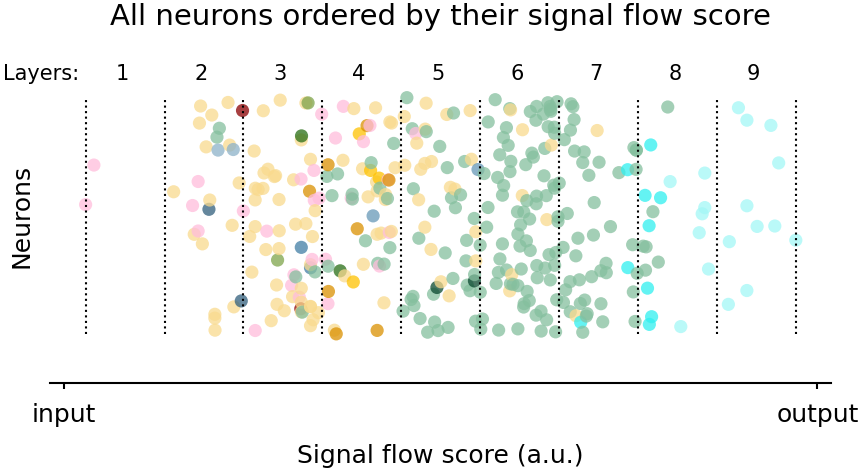

In [15]:
np.random.seed(0)
# plot for each neuron group the distribution of signal flow
with plt.style.context("./config.mplstyle"):

    fig, ax = plt.subplots(
        figsize=(FIGSIZE["width"] * 2.8, FIGSIZE["length"] * 1.6), dpi=300
    )
    y_values = np.random.rand(len(z_sorted))
    ax.vlines(layer_bounds, ymin=np.min(y_values), ymax=np.max(y_values), ls=":", label="layers", color="black")

    ax.scatter(
        z_sorted,
        y_values,
        color=[neurons.ALL_NEURONS_REV_JO[neuron_id]["color"] for neuron_id in nodes],
        alpha=0.75,
        linewidths=0,
        s=10
        # label=neuron_group,
    )
    ax.set_xlabel("Signal flow score (a.u.)")
    ax.set_ylabel("Neurons")
    ax.set_title("All neurons ordered by their signal flow score")
    ax.invert_xaxis()
    ax.set_xticks(
        ticks=[z_sorted.min() - 0.1, z_sorted.max() + 0.1],
        labels=["output", "input"],
    )
    ax.set_yticks(
        ticks=[]
    )
    # write layer numbers
    ax.text(
        x=1.7,
        y=1.1,
        s=f"Layers:",
        ha="right",
        va="center",
        fontsize=5,
    )
    for i, layer_start in enumerate(layer_bounds[:-1]):
        ax.text(
            x=layer_start - 0.2,
            y=1.1,
            s=f"{i + 1}",
            ha="right",
            va="center",
            fontsize=5,
        )
    ax.set_ylim(-.2,1.2)
    ax.spines.left.set_visible(False)

    # ax.legend()
    fig.savefig(EXPORT_PATH / "EDFig7_panelE_signal_flow.png", bbox_inches='tight', dpi=300)
    plt.show()


# Panel F: projection of central neurons onto premotor neurons 

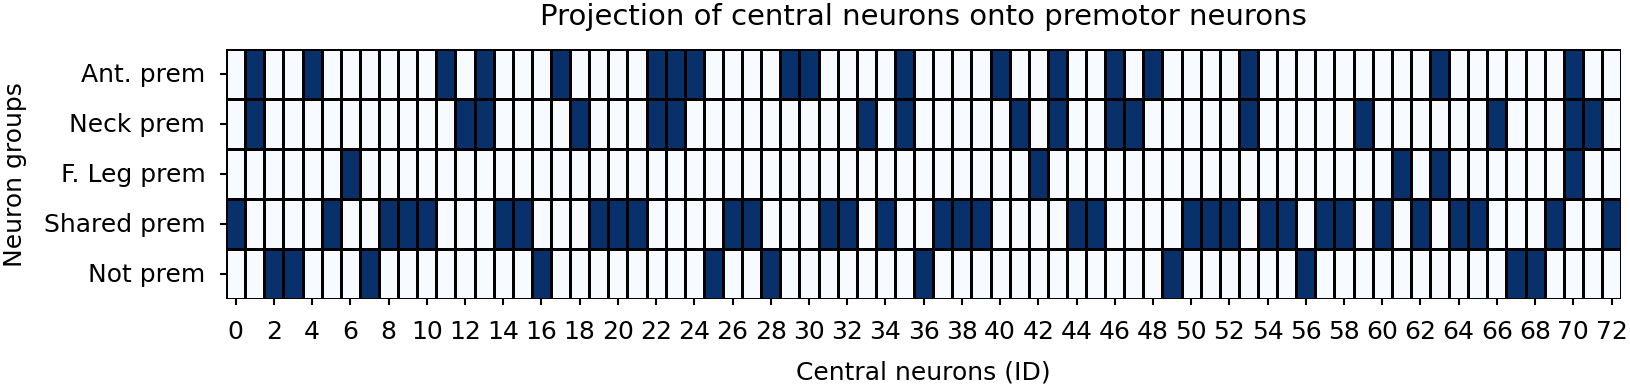

In [16]:
grooming_network = load_data(DATA_PATH / "Fig4_grooming_network_sensory_merged.pkl")
neuron_groups = load_data(DATA_PATH / "Fig4_MN_SN_updated.pkl")

central_array_projection = graph_tools.classify_central_neurons(
    grooming_network, neuron_groups
)

with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 5.0, FIGSIZE["length"] * 1.2)
    )

    sns.heatmap(
        central_array_projection.T,
        cmap="Blues",
        ax=ax,
        cbar=False,
        linewidths=0.3,
        linecolor="black",
    )
    ax.set_yticks(
        np.arange(5) + 0.5,
        labels=["Ant. prem", "Neck prem", "F. Leg prem", "Shared prem", "Not prem"],
        rotation=0,
    )

    ax.set_xlabel("Central neurons (ID)")
    ax.set_ylabel("Neuron groups")
    ax.set_title("Projection of central neurons onto premotor neurons")

    fig.savefig(
        EXPORT_PATH / "EDFig7_panelF.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

## Panel G: premotor neurons in the VNC

Neurons (90) projecting onto leg and neck motor neurons in the VNC are: [ 10016  10052  10058  10086  10089  10091  10093  10095  10097  10102
  10117  10118  10240  10291  10297  10315  10339  10342  10397  10399
  10420  10445  10466  10532  10604  10622  10813  10846  10854  10858
  10952  10981  11253  11264  11349  11354  11426  11740  11741  11917
  12088  12098  12172  12455  12479  12655  12690  12847  12956  13488
  13545  13627  13639  13900  14660  14690  14756  15047  15249  15478
  15562  15718  16746  17287  17475  17514  17651  17717  17834  18652
  18815  18874  18943  19143  19248  19658  20012  20535  20773  20869
  20978  22235  22629  22713  23448  23585  25512 102415 152940 174427]


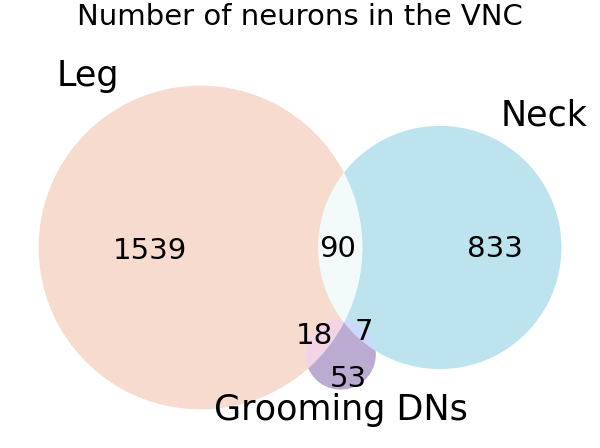

In [17]:
# VNC premotor neurons
neck_prem_df, leg_prem_df, common_prem_df = graph_tools.get_prem_neurons_vnc()

groom_matched_dns_manc = np.load(DATA_PATH / "Fig4_groomingDNs_manc.npy")

leg_prem = set(leg_prem_df.bodyId.values)
neck_prem = set(neck_prem_df.bodyId.values)
groom_dns = set(groom_matched_dns_manc)

with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 2.4, FIGSIZE["length"] * 1.9)
    )
    matplotlib_venn.venn3(
        [leg_prem, neck_prem, groom_dns],
        set_labels=("Leg", "Neck", "Grooming DNs"),
        set_colors=("#E9A686", "#59BAD6", "#592E8E"),
    )
    ax.set_title("Number of neurons in the VNC")
    fig.savefig(
        EXPORT_PATH / "EDFig7_panelG_VNC_prem.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

## Panel H: neuron classes of premotor neurons

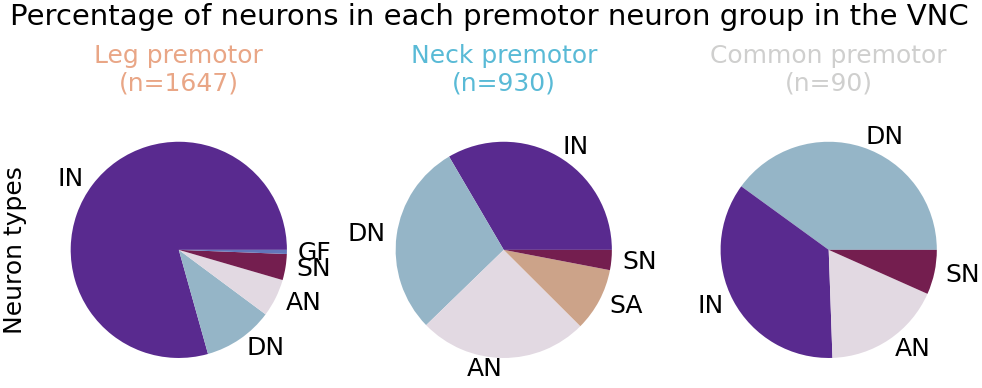

In [18]:
leg_prem_df.loc[:, ["type_group"]] = leg_prem_df["type"].str[:2]
neck_prem_df.loc[:, ["type_group"]] = neck_prem_df["type"].str[:2]
common_prem_df.loc[:, ["type_group"]] = common_prem_df["type"].str[:2]

color_for_neurons = get_color_list("twilight", number=9)

# set colors to all neuron types
type_colors = {
    neuron: color_for_neurons[i]
    for i, neuron in enumerate(["AN", "DN", "GF", "IN", "MN", "SN", "TN", "SA"])
}

with plt.style.context("./config.mplstyle"):
    # Pie chart
    fig, axs = plt.subplots(
        1, 3, figsize=(FIGSIZE["width"] * 3.3, FIGSIZE["length"] * 1.3), dpi=300
    )

    leg_prem_clean = leg_prem_df.groupby("type_group").filter(lambda x: len(x) > 3)
    value_count_leg = leg_prem_clean["type_group"].value_counts()
    value_count_leg.plot(
        kind="pie",
        # autopct="%1.1f%%",
        fontsize=6,
        colors=[type_colors[nt] for nt in value_count_leg.keys()],
        ax=axs[0],
    )
    axs[0].set_title(
        f"Leg premotor\n(n={len(leg_prem_df)})",
        color="#E9A686",
        fontsize=6,
    )

    neck_prem_clean = neck_prem_df.groupby("type_group").filter(lambda x: len(x) > 3)
    value_count_neck = neck_prem_clean["type_group"].value_counts()
    value_count_neck.plot(
        kind="pie",
        # autopct="%1.1f%%",
        fontsize=6,
        colors=[type_colors[nt] for nt in value_count_neck.keys()],
        ax=axs[1],
    )
    axs[1].set_title(
        f"Neck premotor\n(n={len(neck_prem_df)})",
        color="#59BAD6",
        fontsize=6,
    )

    common_prem_clean = common_prem_df.groupby("type_group").filter(
        lambda x: len(x) > 3
    )
    value_count_common = common_prem_clean["type_group"].value_counts()
    value_count_common.plot(
        kind="pie",
        # autopct="%1.1f%%",
        fontsize=6,
        colors=[type_colors[nt] for nt in value_count_common.keys()],
        ax=axs[2],
    )

    axs[2].set_title(
        f"Common premotor\n(n={len(common_prem_df)})",
        color="#CFCFCE",
        fontsize=6,
    )
    axs[0].set_ylabel("Neuron types")
    axs[1].set_ylabel("")
    axs[2].set_ylabel("")

    plt.suptitle(
        "Percentage of neurons in each premotor neuron group in the VNC", y=1.2
    )

    fig.savefig(EXPORT_PATH / "EDFig7_panelH.png", bbox_inches="tight")
    plt.show()